<a href="https://colab.research.google.com/github/SidouPrince/NeuralNetwork/blob/main/tutorial03a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 3a. Homemade one-hidden layer perceptron for binary classification

![](mlp.svg)

## This is a homework: put your names here

- SADI SID ALI

## Description

The goal of this tutorial is to build and train your first neural network *by hand* !

- To keep things as simple as possible we consider a simple *perceptron* with *one hidden layer*
- We consider a binary-classification problem which cannot be solved with a linear classifier
- We use a toy dataset which is already created for you with the `load_data()` function

The neural network will have to be **programmed and trained from scratch**, meaning that you will have to define its structure yourself, and that **you are not allowed** to use the built-in functionalities of `PyTorch` for autodifferentiation. You will have to program the forward and backward pass *yourself*, together with the gradient descent algorithm.

**Read the following instructions carefully in order to succeed**

- You are already provided with a simple python class which will constitute your neural network. 

- The constructor of this class (`__init__`) requires you to specify the following parameters (investigate the data carefully in order to know how these parameters need to be defined).
    - Number of input nodes (number of features)
    - Number of hidden units 
    - Number of output nodes

- The constructor of the neural network also requires you to allocate the weight matrices and bias vectors which will be the main components of your computational graph. For this, you can use some of the tensor operations we have seen in `tutorial2a`, in order to initialize at random the weights, for instance.

- Implementing a neural network consists in two main steps:
    - Forward-pass: computing the output of the network based on its weight matrices and bias vectors. Since we consider binary classification, we should output activations that are activated by a sigmoid
    - Backward-pass: computing how different the predictions of the network are from what should be predicted and update the parameters of the network with the backpropagation algorithm. You are already provided with a loss function in the code which requires only slight modifications.

- If you want to challenge yourself you can extend the neural network as follows:
    - add multiple hidden layers of different sizes
    - explore different non-linear activation functions
    - investigate whether the network starts overfitting

In [1]:
import numpy as np
import matplotlib as plt
import torch
import sklearn
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

## Simulation of the data

In [2]:
def load_data(n_samples=500):
    return make_gaussian_quantiles(
        mean=None,
        cov=0.7,
        n_samples=n_samples,
        n_features=2,
        n_classes=2,
        shuffle=True,
        random_state=42,
    )

In [3]:
gaussian_quantiles = load_data()
X, y = gaussian_quantiles

print(X[:10, :])
print(y[:10])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
type(X_train)


[[-1.13773727  0.62436053]
 [-0.75970745 -1.18161805]
 [-0.82471758  0.42171557]
 [-0.09398039 -0.18487643]
 [-0.80731289  0.57399183]
 [ 0.67980788  1.13471182]
 [-1.70521733 -0.84342552]
 [ 1.57461467  1.12565917]
 [-0.22579357 -0.81889248]
 [ 0.97317262  0.00856159]]
[1 1 0 0 1 1 1 1 0 1]


numpy.ndarray

In [4]:

y_train.shape[0]

400

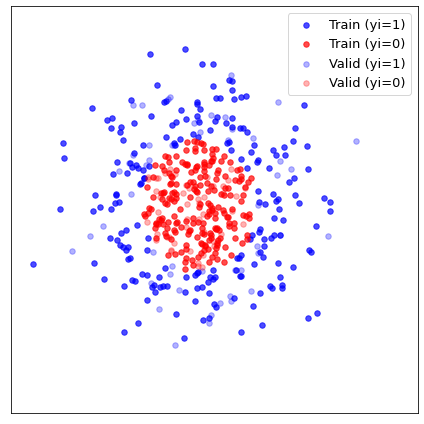

In [5]:
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def plot_data(X, y, xy_labels=True, label=None, **kwargs):
    X_1 = X[y == 1]
    X_0 = X[y == 0]
    if label is not None:
        plt.scatter(X_1[:, 0], X_1[:, 1], c="blue", s=30, label=label + " (yi=1)", **kwargs)
        plt.scatter(X_0[:, 0], X_0[:, 1], c="red", s=30, label=label + " (yi=0)", **kwargs)
    plt.xticks(())
    plt.yticks(())
    plt.xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    plt.ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)

plt.figure(figsize=(6, 6))
plot_data(X_train, y_train, alpha=0.7, label="Train")
plot_data(X_test, y_test, alpha=0.3, label="Valid")
plt.legend(fontsize=13)
plt.tight_layout()

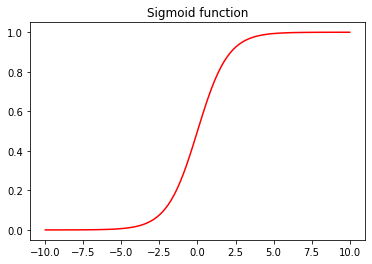

In [6]:
def sigmoid(x):
  return 1/(1+np.exp(-x))

values = np.linspace(-10, 10, 100)
plt.plot(values, sigmoid(values), 'r')
plt.title("Sigmoid function")
plt.show()

In [7]:
def sigmoid_der(x):
  return sigmoid(x)*(1-sigmoid(x))

## A neural network class

**QUESTION.** Implement the `forward` and `backward` methods in the following class, and fill the `__init__` and `train` methods, in order to train the one-hidden layer perceptron for binary classification. 

In [49]:
class NeuralNetwork:
    def __init__(self, n_in, n_hidden, n_out):
        # number of input nodes
        self.n_x = n_in
        # number of hidden nodes
        self.n_h = n_hidden
        # number of output nodes
        self.n_y = n_out
        # Define 1st weight matrix (using random initialization)
        self.W1 = torch.rand(n_hidden, n_in ) * 0.01
        # define 1st bias vector
        self.b1 = torch.rand(n_hidden, 1)
        # Define 2nd weight matrix (using random initialization)
        self.W2 = torch.rand(n_out, n_hidden) * 0.01
        # Define 2nd bias vector
        self.b2 = torch.rand(n_out, 1)
                        
    def forward(self, X):
        z1 = torch.matmul(self.W1, X) + self.b1
        activ1 = torch.tanh(z1)
        self.activ1 = activ1
        z2 = torch.matmul(self.W2, activ1) + self.b2
        self.predicted = sigmoid(z2)
        return self.predicted
    
    def backward(self, X, y):
        m = y.shape[1]
        dz2 = self.predicted - y
        dw2 = 1/m * torch.matmul(dz2, self.activ1.t())
        db2 = 1/m * torch.sum(dz2)#peut etre erreur ici
        dz1 = torch.mul(torch.matmul(self.W2.t(), dz2), (1 - torch.pow(self.activ1, 2)))
        dw1 = 1/m * torch.matmul(dz1, X.t())
        db1 = 1/m * torch.sum(dz1)
        self.dw1 = dw1
        self.dw2 = dw2
        self.db1 = db1
        self.db2 = db2
        
    def train(self, X_train, y_train, X_valid, y_valid, epochs, learning_rate):
        m = X_train.shape[1]
        error_train = []
        for e in range(epochs):
            self.forward( X_train)
        
            training_loss = -torch.sum(torch.mul(torch.log(self.predicted), y_train) + torch.mul(torch.log(1- self.predicted ),  (1 - y_train))) / m # fill in the question marks 
            error_train.append(training_loss)

            self.backward(X_train, y_train)
            self.W1 = self.W1 - learning_rate * self.dw1 # update of the 1st weight matrix
            self.b1 = self.b1 - learning_rate * self.db1 # update of the 1st bias vector
            self.W2 = self.W2 - learning_rate * self.dw2# update of the 2nd weight matrix
            self.b2 = self.b2 - learning_rate * self.db2  # update of the 2nd bias vector
            
            if e % 50 == 0:
              print ("Cost after iteration %i: %f" %(e, training_loss))
        self.error_train = np.array(error_train)
        validation_error = []
        for ep in range(epochs):
          p = self.forward(X_valid_torch)
          validation_loss = -torch.sum(torch.mul(torch.log(p), y_valid) + torch.mul(torch.log(1- p ),  (1 - y_valid))) / m 
          validation_error.append(validation_loss)
        self.validation_error = np.array(validation_error)
        print("error_training :", np.mean(self.error_train))
        print("validation_error", np.mean(self.validation_error))



**QUESTION.** Train your neural network, modify your code to save the training and validation error along the gradient descent iterations and plot them. You should also print the train and validation errors during training.

In [51]:
X_train_torch = torch.from_numpy(X_train).float()
y_train_torch = torch.from_numpy(y_train).float()
X_valid_torch = torch.from_numpy(X_test).float()
y_valid_torch = torch.from_numpy(y_test).float()

X_train_torch = X_train_torch.t()
X_valid_torch = X_valid_torch.t()

y_train_torch = y_train_torch.reshape(1, y_train_torch.shape[0])
y_valid_torch = y_valid_torch.reshape(1, y_valid_torch.shape[0])

nn = NeuralNetwork(2, 2, 1)
print ('Train X Shape: ', X_train_torch.shape)
print ('Train Y Shape: ', y_train_torch.shape)
nn.train(
    X_train_torch,
    y_train_torch,
    X_valid_torch,
    y_valid_torch,
    epochs=2500,
    learning_rate=0.01
)

Train X Shape:  torch.Size([2, 400])
Train Y Shape:  torch.Size([1, 400])
Cost after iteration 0: 0.693946
Cost after iteration 50: 0.693713
Cost after iteration 100: 0.693547
Cost after iteration 150: 0.693429
Cost after iteration 200: 0.693345
Cost after iteration 250: 0.693285
Cost after iteration 300: 0.693242
Cost after iteration 350: 0.693212
Cost after iteration 400: 0.693190
Cost after iteration 450: 0.693175
Cost after iteration 500: 0.693164
Cost after iteration 550: 0.693156
Cost after iteration 600: 0.693150
Cost after iteration 650: 0.693146
Cost after iteration 700: 0.693143
Cost after iteration 750: 0.693141
Cost after iteration 800: 0.693140
Cost after iteration 850: 0.693139
Cost after iteration 900: 0.693138
Cost after iteration 950: 0.693137
Cost after iteration 1000: 0.693137
Cost after iteration 1050: 0.693137
Cost after iteration 1100: 0.693136
Cost after iteration 1150: 0.693136
Cost after iteration 1200: 0.693136
Cost after iteration 1250: 0.693136
Cost after it

In [40]:
def prediction(X):
  pred = nn.forward(X)
  print(pred)
  return torch.round(pred)

In [42]:
prediction(X_valid_torch)

tensor([[0.4937, 0.4964, 0.4951, 0.4929, 0.4945, 0.4990, 0.4957, 0.4919, 0.5045,
         0.4957, 0.5006, 0.4932, 0.5041, 0.4939, 0.4981, 0.4986, 0.4892, 0.4941,
         0.5063, 0.4971, 0.4962, 0.4942, 0.4966, 0.4935, 0.4970, 0.4970, 0.4983,
         0.4918, 0.5048, 0.4889, 0.5079, 0.4997, 0.5000, 0.4958, 0.4953, 0.5008,
         0.5022, 0.5014, 0.4967, 0.4986, 0.4921, 0.4956, 0.4903, 0.4987, 0.4915,
         0.5008, 0.4948, 0.4971, 0.5112, 0.4956, 0.4896, 0.4966, 0.5006, 0.4940,
         0.4940, 0.4923, 0.4937, 0.4926, 0.4929, 0.4965, 0.4969, 0.4956, 0.5035,
         0.5035, 0.4949, 0.4976, 0.4954, 0.4961, 0.4930, 0.5009, 0.4970, 0.4994,
         0.5007, 0.4876, 0.4959, 0.4933, 0.4961, 0.4930, 0.4961, 0.4980, 0.4939,
         0.4938, 0.5010, 0.4917, 0.4950, 0.4983, 0.5026, 0.4954, 0.4903, 0.5031,
         0.4971, 0.5003, 0.5034, 0.4950, 0.4935, 0.4934, 0.4986, 0.4984, 0.4958,
         0.4988]])


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1.,
         1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
         0., 1., 1., 0., 0., 0., 0., 0., 0., 0.]])

## Assessment of your model

**QUESTION.** Use and modify the plotting functions from this notebook and the ones from `tutorial01` in order to plot the data together with the **predicted probabilities** of your neural network for inputs in a grid covering the input features space (as we did in `tutorial01`). Also, display on the plot the AUC-ROC metric obtained by your neural net.